In [1]:
def get_data(origin,maximum, Lleyland = False, Brett = True, Petroleum = True, Model = 1):
    bore_info = pd.read_excel(
    "../data/data_dwer\geology.xls", sheet_name="bore_info"
    )
    
    df = bore_info.copy()
    x0, x1, y0, y1, z0, z1 = origin[0], maximum[0], origin[1], maximum[1], origin[2], maximum[2]
    df = df.loc[(df["Northing"] >= y0)]
    df = df.loc[(df["Northing"] <= y1)]
    df = df.loc[(df["Easting"] >= x0)]
    df = df.loc[(df["Easting"] <= x1)]
    if Model == 1:
        df = df.loc[(df["A_model"] == 1)]
    else:
        df = df.loc[(df["B_model"] == 1)]
    df = df.reset_index(drop=True)

    #lithcodes = list(df.columns.values[3:])  # Make a list of formations
    df.Easting = pd.to_numeric(df.Easting)
    df.Northing = pd.to_numeric(df.Northing)
    df.Ground = pd.to_numeric(df.Ground)
    
    
    strat_info = pd.read_excel(
    "../data/data_dwer\geology.xls", sheet_name="strat_info"
    )
    lithcodes = list(strat_info['unit'])
    print(lithcodes)
    strat = []

    for i, lith in enumerate(lithcodes):
        index = i
        lithid = i - 1
        val = strat_info.loc[strat_info["unit"] == lith, "val"].item()
        sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
        R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
        G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
        B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
        strat.append(
            [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
        )
    strat = pd.DataFrame(strat)
    strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]

    data_list = df.values.tolist()  # Turn data into a list of lists
    formatted_data = []
    for i in range(len(data_list)):  # iterate for each row
        end = False
        # okay, first we will establish the max value (i.e. the end of the hole)
        stuff = []
        for j in range(5,27):
            if isinstance(data_list[i][j], numbers.Number) == True:
                stuff.append(data_list[i][j])

        EOH = max(stuff)
        #print(EOH)

        boreid = data_list[i][3]
        easting, northing = data_list[i][0], data_list[i][1]
        groundlevel = data_list[i][4]
        # First channp.nan, np.nan, np.nange - we can get the norms from the geophys data...
        gx, gy, gz = 0.0, 0.0, 1.0  # np.nan, np.nan,np.nan

        # Add data for groundlevel
        val = strat.vals[0]
        formatted_data.append(
            [
                boreid,
                easting,
                northing,
                groundlevel,
                val,
                "Ground",
                "Quaternary",
                gx,
                gy,
                gz,
                "raw_data"
            ]
        )  # eventually we cn get this from a dem...
        current_bottom = np.copy(groundlevel)
        
        #Quaternary Unconformity
        if isinstance(data_list[i][5], numbers.Number) == True:
            bottom = groundlevel - float(data_list[i][5])  # Ground surface - TQ (mbgl)
            val = strat.vals[1]  # designated isovalue
            lithid = lithcodes[1]  # lithology id
            feat_name = strat.sequences[1]  # sequence name
            formatted_data.append(
                [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
            )
            current_bottom = np.copy(bottom)
        #Kings park
        if isinstance(data_list[i][8], numbers.Number) == True:
            bottom = groundlevel - float(data_list[i][8])  # Ground surface - kinhs park base (mbgl)
            val = strat.vals[2]  # designated isovalue
            lithid = lithcodes[2]  # lithology id
            feat_name = strat.sequences[2]  # sequence name
            formatted_data.append(
                [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
            )
            current_bottom = np.copy(bottom)  
        #Tertiaty_unconformity
        bottom = np.copy(current_bottom)  # current depth
        val = 0  # designated isovalue
        lithid = 'base_tert'  # lithology id
        feat_name = "Tert_U"  # sequence name
        formatted_data.append(
            [boreid, easting, northing, bottom, val, lithid, feat_name, 0, 0, 1,"raw_data"]
        )
        #Lancelin formation
        ldum = [3,4,5]
        cdum = [11,12,13]
        for j in range(3):
            if isinstance(data_list[i][cdum[j]], numbers.Number) == True:
                bottom = groundlevel - float(data_list[i][cdum[j]])  # Ground surface - kinhs park base (mbgl)
                val = strat.vals[ldum[j]]  # designated isovalue
                lithid = lithcodes[ldum[j]]  # lithology id
                feat_name = strat.sequences[ldum[j]]  # sequence name
                formatted_data.append(
                    [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
                )
                current_bottom = np.copy(bottom)              

        #Lancelin _ unconformity
        bottom = np.copy(current_bottom)  # current depth
        val = 0  # designated isovalue
        lithid = 'base_lanc'  # lithology id
        feat_name = "Lanc_U"  # sequence name
        formatted_data.append(
            [boreid, easting, northing, bottom, val, lithid, feat_name, 0, 0, 1,"raw_data"]
        )

        #Osbourne_formation
        ldum = [6,7,8]
        cdum = [14,15,17]
        for j in range(3):
            if isinstance(data_list[i][cdum[j]], numbers.Number) == True:
                bottom = groundlevel - float(data_list[i][cdum[j]])  # Ground surface - kinhs park base (mbgl)
                val = strat.vals[ldum[j]]  # designated isovalue
                lithid = lithcodes[ldum[j]]  # lithology id
                feat_name = strat.sequences[ldum[j]]  # sequence name
                formatted_data.append(
                    [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
                )
                current_bottom = np.copy(bottom)     

        #Osbourne _ unconformity
        bottom = np.copy(current_bottom)  # current depth
        val = 0  # designated isovalue
        lithid = 'base_Osb'  # lithology id
        feat_name = "Osb_U"  # sequence name
        formatted_data.append(
            [boreid, easting, northing, bottom, val, lithid, feat_name, 0, 0, 1,"raw_data"]
        )

        #Leedervilles
        ldum = [9,10,11]
        cdum = [18,19,20]
        for j in range(3):
            if isinstance(data_list[i][cdum[j]], numbers.Number) == True:
                if float(data_list[i][cdum[j]]) < EOH:
                    bottom = groundlevel - float(data_list[i][cdum[j]])  # Ground surface - kinhs park base (mbgl)
                    val = strat.vals[ldum[j]]  # designated isovalue
                    lithid = lithcodes[ldum[j]]  # lithology id
                    feat_name = strat.sequences[ldum[j]]  # sequence name
                    formatted_data.append(
                        [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
                    )
                    current_bottom = np.copy(bottom)         
        #Leederville _ unconformity
        bottom = np.copy(current_bottom)  # current depth
        val = 0  # designated isovalue
        lithid = 'base_Leed'  # lithology id
        feat_name = "Leed_U"  # sequence name
        formatted_data.append(
            [boreid, easting, northing, bottom, val, lithid, feat_name, 0, 0, 1,"raw_data"]
        )

        #SPS and Gage
        ldum = [12,13]
        cdum = [21,22]
        for j in range(2):
            if isinstance(data_list[i][cdum[j]], numbers.Number) == True:
                if float(data_list[i][cdum[j]]) < EOH:
                    bottom = groundlevel - float(data_list[i][cdum[j]])  # Ground surface - kinhs park base (mbgl)
                    val = strat.vals[ldum[j]]  # designated isovalue
                    lithid = lithcodes[ldum[j]]  # lithology id
                    feat_name = strat.sequences[ldum[j]]  # sequence name
                    formatted_data.append(
                        [boreid, easting, northing, bottom, val, lithid, feat_name, gx, gy, gz,"raw_data"]
                    )
                    current_bottom = np.copy(bottom)          
        #Warnbro _ unconformity
        bottom = np.copy(current_bottom)  # current depth
        val = 0  # designated isovalue
        lithid = 'base_Warn'  # lithology id
        feat_name = "Warn_U"  # sequence name
        formatted_data.append(
            [boreid, easting, northing, bottom, val, lithid, feat_name, 0, 0, 1,"raw_data"]
        )

        #Yaragadee, or parmelias, no real yaragadee bases
        ldum = [14,15,16]
        cdum = [23,24,25]
        for j in range(3):
            if isinstance(data_list[i][cdum[j]], numbers.Number) == True:
                if float(data_list[i][cdum[j]]) < EOH:
                    bottom = groundlevel - float(data_list[i][cdum[j]])  # Ground surface - kinhs park base (mbgl)
                    val = strat.vals[ldum[j]]  # designated isovalue
                    lithid = lithcodes[ldum[j]]  # lithology id
                    feat_name = strat.sequences[ldum[j]]  # sequence name
                    formatted_data.append(
                        [boreid, easting, northing, bottom, val, lithid, feat_name, np.nan, np.nan, np.nan,"raw_data"]
                    )
                    current_bottom = np.copy(bottom)          

                
    data = pd.DataFrame(formatted_data)
    data.columns = [
        "ID",
        "X",
        "Y",
        "Z",
        "val",
        "lithcode",
        "feature_name",
        "gx",
        "gy",
        "gz",
        "for_Kerry"
    ]
    
    if Lleyland:
        valdum = [0.,-44.,0.,0.,-440,-607,-660,-783,0][::-1]
        feature = ['Quaternary','Quaternary','Tert_U','Osb_U',
                   'Leederville','Leederville','Leederville'
                   ,'Warnbro','Warn_U']
        
        ddum = []
        Lley = pd.read_excel(
        "../data/data_dwer\geology.xls", sheet_name="Lleyland"
        )

        for i in range(len(Lley)):
            BoreID = Lley["Name"][i]
            X = Lley["East"][i]
            Y = Lley["North"][i]
            LSE = Lley["Ground"][i]
            ddum.append([BoreID, X, Y, LSE, valdum[-1], 'Lley', feature[0], 0.0, 0.0, 1.0,"Lucy"])
            ddum.append([BoreID, X, Y, LSE-Lley["Break up"][i], valdum[8], 'Lley', feature[8], 0.0, 0.0, 1.0,"Lucy"]) 
            if type(Lley["SPS"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["SPS"][i], valdum[7], 'Lley', feature[7], 0.0, 0.0, 1.0,"Lucy"])
            if type(Lley["Maringiniup"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Maringiniup"][i], valdum[6], 'Lley', feature[6], 0.0, 0.0, 1.0,"Lucy"])            
            ddum.append([BoreID, X, Y, LSE-Lley["Waneroo"][i], valdum[5], 'Lley', feature[5], 0.0, 0.0, 1.0,"Lucy"])
            if type(Lley["Pinjar"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Pinjar"][i], valdum[4], 'Lley', feature[4], 0.0, 0.0, 1.0,"Lucy"])                    
            ddum.append([BoreID, X, Y, LSE-Lley["Aptian"][i], valdum[3], 'Lley', feature[3], 0.0, 0.0, 1.0,"Lucy"])   
            if type(Lley["Paleocene"][i]) == type(1):
                ddum.append([BoreID, X, Y, LSE-Lley["Paleocene"][i], valdum[2], 'Lley', feature[2], 0.0, 0.0, 1.0,"Lucy"]) 
            ddum.append([BoreID, X, Y, LSE-Lley["TQ"][i], valdum[1], 'Lley', feature[1], 0.0, 0.0, 1.0,"Lucy"]) 

        data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)])
        
    if Brett:
        gphys = pd.read_excel(
        "../data/data_dwer\geology.xls", sheet_name="Other_constraints")
        ddum = []
        for i in range(len(gphys)):
            ddum.append(['GEO', gphys["Easting"][i], gphys["Northing"][i], gphys["z"][i], gphys["val"][i], 'GEO', gphys["Feature"][i], 0.0, 0.0, 1.0,"Brett"]) 

        data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)]) 

    if Petroleum:
        Pet = pd.read_excel(
        "../data/data_dwer\geology.xls", sheet_name="Petroleum_readable")
        ddum = []
        for i in range(len(Pet)):
            ddum.append(['PET',Pet["X"][i], Pet["Y"][i], Pet["Z"][i], Pet["val"][i],Pet['lithcode'][i], Pet["feature_name"][i], np.nan, np.nan, np.nan,"WAPIMS"]) 

        data = pd.concat([data,pd.DataFrame(ddum,columns = data.columns)])        
        
        
    return(data,lithcodes)
   

    

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:242: SyntaxWarning: invalid escape sequence '\g'
<>:268: SyntaxWarning: invalid escape sequence '\g'
<>:277: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:242: SyntaxWarning: invalid escape sequence '\g'
<>:268: SyntaxWarning: invalid escape sequence '\g'
<>:277: SyntaxWarning: invalid escape sequence '\g'
C:\Users\00098687\AppData\Local\Temp\ipykernel_26588\1158470578.py:3: SyntaxWarning: invalid escape sequence '\g'
  "../data/data_dwer\geology.xls", sheet_name="bore_info"
C:\Users\00098687\AppData\Local\Temp\ipykernel_26588\1158470578.py:25: SyntaxWarning: invalid escape sequence '\g'
  "../data/data_dwer\geology.xls", sheet_name="strat_info"
C:\Users\00098687\AppData\Local\Temp\ipykernel_26588\1158470578.py:242: SyntaxWarning: invalid escape sequence '\g'
  "../data/data_dwer\geo

In [2]:
def make_strat_column(lithcodes):
    strat_info = pd.read_excel(
    "../data/data_dwer\geology.xls", sheet_name="strat_info"
    )
    
    strat = []
    
    vdum = [ 0,
            -44,
            -161,
            -186,
            -230,
            -253,
            -313,
            -364,
            -386,
            -440,
            -607,
            -660,
            -783,
            -883,
            -1181,
            -1358,
            -1418,
            -4418,
            -4558]

    for i, lith in enumerate(lithcodes):
        index = i
        lithid = i - 1
        val = vdum[i]
        sequence = strat_info.loc[strat_info["unit"] == lith, "sequence"].item()
        R = strat_info.loc[strat_info["unit"] == lith, "R"].item() / 255
        G = strat_info.loc[strat_info["unit"] == lith, "G"].item() / 255
        B = strat_info.loc[strat_info["unit"] == lith, "B"].item() / 255
        strat.append(
            [index, lithid, lith, sequence, val, [round(R, 2), round(G, 2), round(B, 2)]]
        )
    strat = pd.DataFrame(strat)
    strat.columns = ["index", "lithid", "lithcode", "sequences", "vals", "color"]
    
    stratigraphic_column = {}
    stratigraphic_column["Ground"] = {}
    stratigraphic_column["Quaternary"] = {}
    stratigraphic_column["Tertiary"] = {}
    stratigraphic_column["Lancelin"] = {}
    stratigraphic_column["Osbourne"] = {}
    stratigraphic_column["Leederville"] = {}
    stratigraphic_column["Warnbro"] = {}
    stratigraphic_column["Yarragadee"] = {}

    tops = [0,5,6,7,8,11,14,17,19,22]
    bots = [5,6,7,10,13,16,18,21,22]
    for i in range(0, len(strat) - 1, 1):
        if i in tops:
            maxval = np.inf
        else:
            maxval = strat.vals[i - 1]
        if i in bots:
             minval = -np.inf
        else:
            minval = strat.vals[i]       
        stratigraphic_column[strat.sequences[i]][strat.lithcode[i]] = {
            "min": minval,
            "max": maxval,
            "id": i,
            "color": strat.color[i],
        }
        
    return(stratigraphic_column,strat)


<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\00098687\AppData\Local\Temp\ipykernel_26588\1593150343.py:3: SyntaxWarning: invalid escape sequence '\g'
  "../data/data_dwer\geology.xls", sheet_name="strat_info"


In [3]:


def make_fault_cloud(fx,fy):

    from LoopStructural.utils import strikedip2vector as strike_dip_vector
    x = []
    y = []
    z = []
    nx, ny, nz = [],[],[]
    for ff in range (len(fx) - 1):
        dum_angle = np.rad2deg(np.arctan(np.abs(fy[ff+1] - fy[ff]) / np.abs(fx[ff+1] - fx[ff])))
        if fx[ff+1] > fx[ff]:
            fault_azimuth = 90 - dum_angle
        else:
            fault_azimuth = 90 - dum_angle
        strike, dip = fault_azimuth, 270
        nx1, ny1, nz1 = strike_dip_vector([strike], [dip])[0]
        for i in range (50):
            for k in range(20):
                x.append(fx[ff] + (fx[ff+1]-fx[ff])/49*float(i)-k*25.)
                y.append(fy[ff] + (fy[ff+1]-fy[ff])/49*float(i))
                z.append(-200)
                nx.append(nx1)
                ny.append(ny1)
                nz.append(nz1)

    fault_plane_3d = []
    rows = []
    for i in range(len(x)):
        fault_plane_3d.append((x[i], y[i], z[i]))
        df_new_row = pd.DataFrame.from_records(
            {
                "X": [x[i]],
                "Y": [y[i]],
                "Z": [z[i]],
                "val": [0.0],
                "feature_name": ["Fault"],
                "nx": [nx[i]],
                "ny": [ny[i]],
                "nz": [nz[i]],
                "for_Kerry" : ["Fault_cloud"]
            }
        )
        rows.append(df_new_row)
    return(rows)

In [4]:
import pandas as pd
import numpy as np
import numbers

class GM:
    
    def __init__(self,origin,maximum):
        self.basedata,lithcodes = get_data(origin,maximum)
        self.origin = origin
        self.maximum = maximum
        self.is_fault = False
        self.is_CP = False
        self.strat_column, self.strat = make_strat_column(lithcodes)
        self.lithcodes = lithcodes
        self.cret=False
    
    def add_fault(self,faultx,faulty,dmax,cret = True):
        self.is_fault = True
        self.dmax = dmax
        self.cret = cret
        self.fault_rows = make_fault_cloud(faultx,faulty) 
        from LoopStructural.modelling.features.fault._fault_function import (
            CubicFunction,
            FaultDisplacement,
            Composite,
        )
        hw = CubicFunction()
        hw.add_cstr(0, 1)
        hw.add_grad(0, 0)
        hw.add_cstr(1, 0)
        hw.add_grad(1, 0)
        hw.add_max(1)
        fw = CubicFunction()
        fw.add_cstr(0, -1)
        fw.add_grad(0, 0)
        fw.add_cstr(-1, 0)
        fw.add_grad(-1, 0)
        fw.add_min(-1)
        gyf = CubicFunction()
        gyf.add_cstr(-1, 0)
        gyf.add_cstr(1, 0)
        gyf.add_cstr(-0.2, 1)
        gyf.add_cstr(0.2, 1)
        gyf.add_grad(0, 0)
        gyf.add_min(-1)
        gyf.add_max(1)
        gzf = CubicFunction()
        gzf.add_cstr(-1, 0)
        gzf.add_cstr(1, 0)
        gzf.add_cstr(-0.2, 1)
        gzf.add_cstr(0.2, 1)
        gzf.add_grad(0, 0)
        gzf.add_min(-1)
        gzf.add_max(1)
        gxf = Composite(hw, fw)
        fault_displacement = None
        fault_displacement = FaultDisplacement(gx=gxf, gy=gyf, gz=gzf)
        self.faultfunction = fault_displacement
        
        
    def add_control_points(self,x,y,z,val,feat):
        self.is_CP = True
        if type(x) == type(1.) or type(x) == type(1):
            df_new_row = pd.DataFrame.from_records(
                {
                "X": [x],
                "Y": [y],
                "Z": [z],
                "val": [val],
                "feature_name": [feat],
                "nx": [0],
                "ny": [0],
                "nz": [1],
                "for_Kerry": ['Control_point']
                }
                )
            self.CP_rows = [df_new_row]
        else:
            self.CP_rows = []
            for i in range(len(x)):
                df_new_row = pd.DataFrame.from_records(
                    {
                        "X": [x[i]],
                        "Y": [y[i]],
                        "Z": [z[i]],
                        "val": [val[i]],
                        "feature_name": [feat[i]],
                        "nx": [0],
                        "ny": [0],
                        "nz": [1],
                        "for_Kerry": ['Control_point']
                    }
                )
                self.CP_rows.append(df_new_row)
            
        
    def make_geomodel(self):
        #compile masyter data
        data = self.basedata.copy()
        if self.is_fault:
            for frow in self.fault_rows:
                data = pd.concat([data,frow], ignore_index=True)         
        if self.is_CP:
            for CP in self.CP_rows:
                data = pd.concat([data,CP], ignore_index=True)   
                
        data["Z"] = data["Z"].astype(float)        
        #make loopmodel
        from LoopStructural import GeologicalModel
        self.geomodel = GeologicalModel(
                                        self.origin, 
                                        self.maximum
                                        )  
        #add data
        self.geomodel.data = data
        
        #add foliations

        Ground = self.geomodel.create_and_add_foliation(
            "Ground", nelements=1e4, buffer=0.1
        )
        #First add the quaternary formation
        Quat = self.geomodel.create_and_add_foliation(
            "Quaternary", nelements=1e4, buffer=0.1
        )
        Tert = self.geomodel.create_and_add_foliation(
            "Tertiary", nelements=1e4, buffer=0.1
        )
        TertUC =self.geomodel.create_and_add_foliation(
            "Tert_U", nelements=1e4, buffer=0.1
        )
        UC1 = self.geomodel.add_onlap_unconformity(
            self.geomodel["Tert_U"], 0.
        )
        Lanc = self.geomodel.create_and_add_foliation(
            "Lancelin", nelements=1e4, buffer=0.1
        )
        Lancelin_UC = self.geomodel.create_and_add_foliation(
            "Lanc_U", nelements=1e4, buffer=0.1
        )
        UC2 = self.geomodel.add_onlap_unconformity(
            self.geomodel["Lanc_U"], 0
        )
        Osb = self.geomodel.create_and_add_foliation(
            "Osbourne", nelements=1e4, buffer=0.1
        )

        Osbourne_UC = self.geomodel.create_and_add_foliation(
            "Osb_U", nelements=1e4, buffer=0.1
        )
        UC3 = self.geomodel.add_onlap_unconformity(
            self.geomodel["Osb_U"], 0
        )
       
        if self.cret and self.is_fault:
            fault_slip_vector = [0.0, 0, 0.001]
            Fault_1 = self.geomodel.create_and_add_fault(
                "Fault",
                displacement=self.dmax,
                fault_slip_vector=fault_slip_vector,
                minor_axis=10000.,  
                faultfunction = self.faultfunction,
                force_mesh_geometry=True,
                nelements=1e3,
            )
        LEED = self.geomodel.create_and_add_foliation(
            "Leederville", nelements=1e4, buffer=0.1
        )
        LEED_UC = self.geomodel.create_and_add_foliation(
            "Leed_U", nelements=1e4, buffer=0.1
        )
        UC4 = self.geomodel.add_onlap_unconformity(
            self.geomodel["Leed_U"], 0
        )
        #SPS and/ or Gage can go missing 
        WARN = self.geomodel.create_and_add_foliation(
            "Warnbro", nelements=1e4, buffer=0.1
        )
        
        WARN_UC = self.geomodel.create_and_add_foliation(
            "Warn_U", nelements=1e4, buffer=0.1
        )
        UC5 = self.geomodel.add_onlap_unconformity(
            self.geomodel["Warn_U"], 0
        )
            
        if not self.cret and self.is_fault:
            print("Here")
            fault_slip_vector = [0.0, 0, 0.001]
            Fault_1 = self.geomodel.create_and_add_fault(
                "Fault",
                displacement=self.dmax,
                fault_slip_vector=fault_slip_vector,
                minor_axis=10000.,  
                faultfunction = self.faultfunction,
                force_mesh_geometry=True,
                nelements=1e3,
            )
        YARR = self.geomodel.create_and_add_foliation(
            "Yarragadee", nelements=1e4, buffer=0.1
        )
        #add strat_column
        self.geomodel.set_stratigraphic_column(self.strat_column)
        #think about updating modle here...
        self.geomodel.update()
        #makes self.geomodel
        
        

In [5]:
x0, x1, y0, y1, z0, z1 = 343000, 408000, 6483000, 6564000, -3500, 300
origin = np.array([x0, y0, z0]).astype(float)
maximum = np.array([x1, y1, z1]).astype(float)
print(origin,maximum)
dmax = [50.,100.,150.,200.]
model = GM(origin,maximum)
model.make_geomodel()


[ 3.430e+05  6.483e+06 -3.500e+03] [4.080e+05 6.564e+06 3.000e+02]
['Ground', 'TQ', 'Tk', 'Kcp', 'Kcg', 'Kcm', 'Kcom', 'Kcok', 'Kcoh', 'Kwlp', 'Kwlw', 'Kwlm', 'Kws', 'Kwg', 'Kpc', 'Kps', 'Kpo', 'Jy', 'Jd']


  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
x = np.linspace(x0,x1,1000)
z = np.linspace(-1200,z1,200)
X,Z = np.meshgrid(x,z)
Y = np.ones_like(X)*6558000
data = model.geomodel.evaluate_feature_value("Leederville",
                                             np.array([X.flatten(),Y.flatten(),Z.flatten()]).T).reshape(np.shape(X))

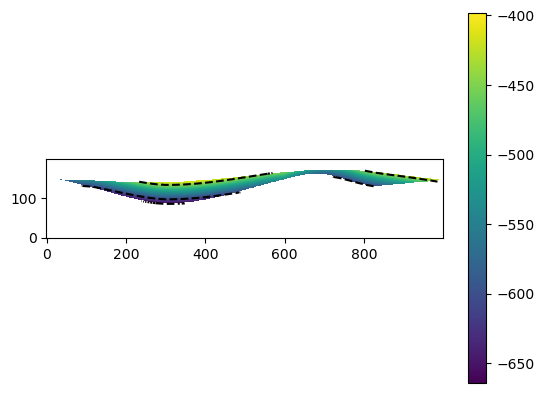

In [7]:
import pylab as plt
plt.imshow(data,origin = 'lower')
plt.colorbar()
plt.contour(data,[-440,-607,-660][::-1],colors = 'k')


In [94]:

plt.imshow(Lmod.geomodel.evaluate_feature_value("NC9_FEAT",
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx)),origin = "lower") 
plt.colorbar()
plt.contour(Lmod.geomodel.evaluate_feature_value("NC9_FEAT",
            np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T
        ).reshape(np.shape(xx)),[0.1])

NameError: name 'plt' is not defined